In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import seaborn as sns

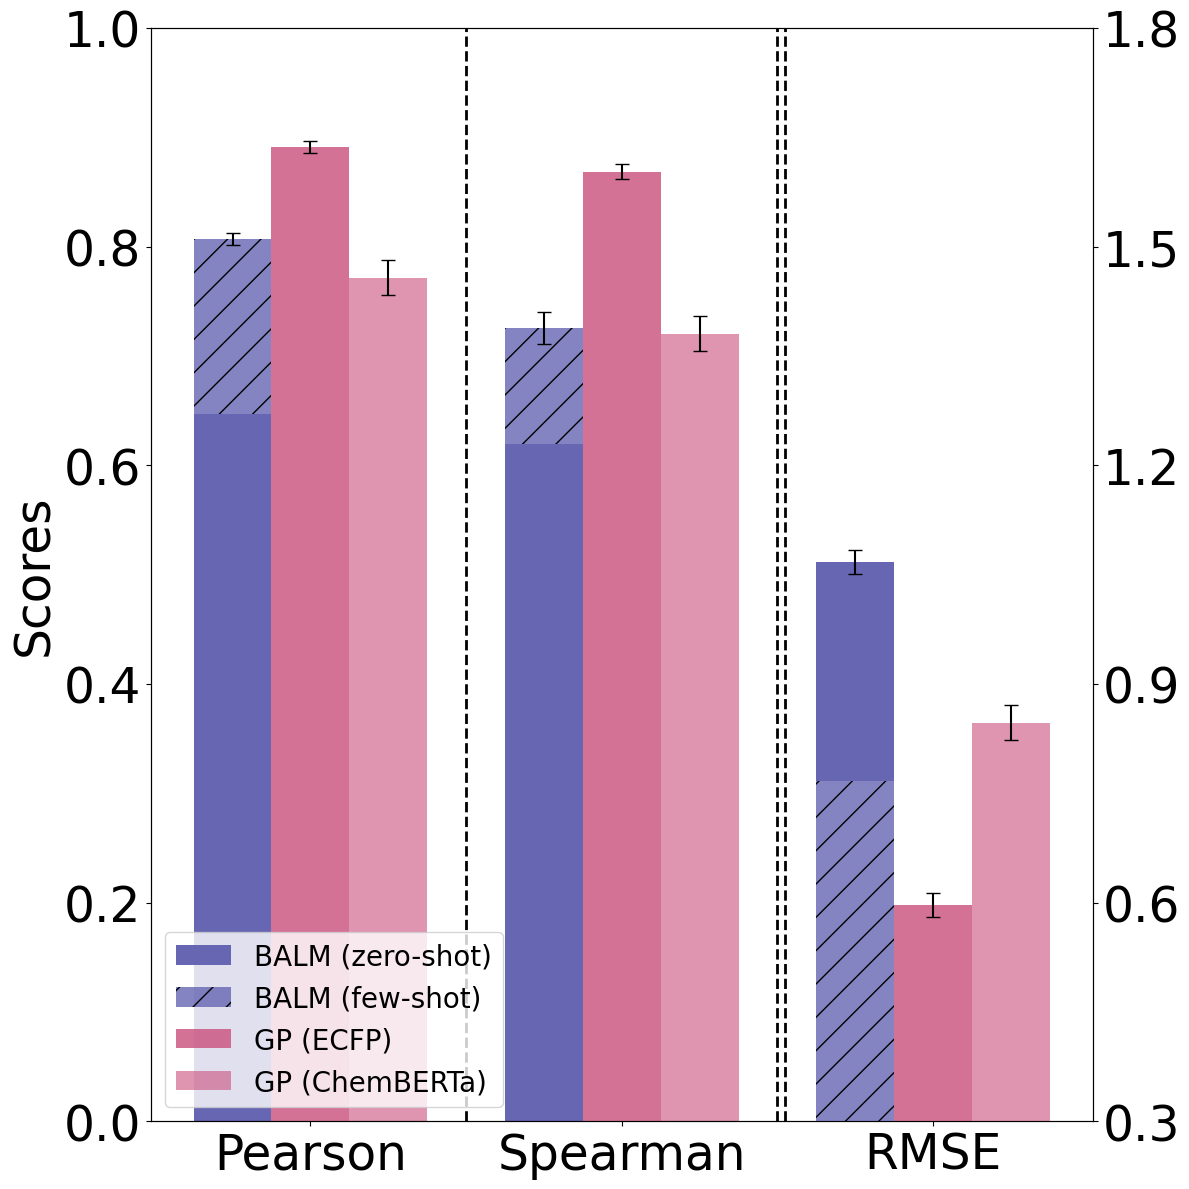

In [67]:

# Load the provided CSV files
file_path_1 = 'USP7/USP7_preds+GP_final.csv'
file_path_2 = 'USP7/USP7_f_zershot_BDBClean.csv'
df_preds_gp = pd.read_csv(file_path_1)
df_zero_shot = pd.read_csv(file_path_2)

# Calculate zero-shot metrics for BALM
labels = df_zero_shot['label']
predictions = df_zero_shot['prediction']
zero_shot_metrics = {
    'Pearson': labels.corr(predictions, method='pearson'),
    'Spearman': labels.corr(predictions, method='spearman'),
    'RMSE': mean_squared_error(labels, predictions, squared=False)
}
balm_zero_shot_values = [zero_shot_metrics['Pearson'], zero_shot_metrics['Spearman'], zero_shot_metrics['RMSE']]

# Filter for few-shot (train_ratio=0.2) for BALM, GP_ECFP, and GP_ChemBERTa
metrics = ['test/pearson', 'test/spearman', 'test/rmse']
balm_few_shot = df_preds_gp[(df_preds_gp['Model'] == 'BALM') & (df_preds_gp['train_ratio'] == 0.2)]
gp_ecfp = df_preds_gp[(df_preds_gp['Model'] == 'GP_ECFP') & (df_preds_gp['train_ratio'] == 0.2)]
gp_chemberta = df_preds_gp[(df_preds_gp['Model'] == 'GP_ChemBERTa') & (df_preds_gp['train_ratio'] == 0.2)]

# Calculate standard deviation for error bars for few-shot entries
balm_few_shot_std = balm_few_shot[metrics].std().values
gp_ecfp_std = gp_ecfp[metrics].std().values
gp_chemberta_std = gp_chemberta[metrics].std().values

# Reconfirm RMSE values for accuracy
rmse_values = {
    'BALM_few_shot_rmse': balm_few_shot['test/rmse'].values[0] if not balm_few_shot.empty else None,
    'GP_ECFP_rmse': gp_ecfp['test/rmse'].values[0] if not gp_ecfp.empty else None,
    'GP_ChemBERTa_rmse': gp_chemberta['test/rmse'].values[0] if not gp_chemberta.empty else None,
    'BALM_zero_shot_rmse': zero_shot_metrics['RMSE']  # Previously calculated zero-shot RMSE
}

# Plotting setup with primary and secondary y-axes
fig, ax = plt.subplots(figsize=(12, 12))
ax1 = ax.twinx()
x = np.arange(len(metrics))
bar_width = 0.25

# Colors
balm_color = sns.color_palette([(0.4, 0.4, 0.7)]) # '#6A5ACD'  # medium slate blue 
gp_color = '#CA4F7C'

# Plot BALM for Pearson and Spearman on primary axis, RMSE on secondary axis
ax.bar(x[:2] - bar_width, balm_zero_shot_values[:2], width=bar_width, color=balm_color, label="BALM (zero-shot)")
ax.bar(x[:2] - bar_width, balm_few_shot[metrics[:2]].values[0] - balm_zero_shot_values[:2], 
       bottom=balm_zero_shot_values[:2], width=bar_width, color=balm_color, alpha=0.8, 
       hatch='/', label="BALM (few-shot)", yerr=balm_few_shot_std[:2], capsize=5)

# Plot RMSE for BALM on secondary axis with few-shot below, zero-shot difference on top
few_shot_rmse = rmse_values['BALM_few_shot_rmse']
zero_shot_rmse = rmse_values['BALM_zero_shot_rmse']
rmse_difference = zero_shot_rmse - few_shot_rmse
ax1.bar(x[2] - bar_width, few_shot_rmse, width=bar_width, color=balm_color, alpha=0.8, hatch='/')
ax1.bar(x[2] - bar_width, rmse_difference, bottom=few_shot_rmse, width=bar_width, color=balm_color, 
       yerr=balm_few_shot_std[2], capsize=5)

# Plot GP_ECFP with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2], gp_ecfp[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
       label="GP (ECFP)", yerr=gp_ecfp_std[:2], capsize=5)
ax1.bar(x[2], gp_ecfp[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
        yerr=gp_ecfp_std[2], capsize=5)

# Plot GP_Chemberta with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2] + bar_width, gp_chemberta[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
       label="GP (ChemBERTa)", yerr=gp_chemberta_std[:2], capsize=5)
ax1.bar(x[2] + bar_width, gp_chemberta[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
        yerr=gp_chemberta_std[2], capsize=5)

# Add double dotted lines to separate metrics
for i in [0.5, 1.5]:
    ax.axvline(x=i, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)
ax.axvline(x=1.525, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)

# Customize y-axes
ax.set_ylim([0, 1])
ax.set_yticks([0 + i * 0.2 for i in range(6)])
ax1.set_ylim([0.3, 1.8])
ax1.set_yticks([0.3 + i * 0.3 for i in range(6)])

# Customize x-axis and remove x-axis label
metric_names = ["Pearson", "Spearman", "RMSE"]
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=35)
ax.set_ylabel('Scores', fontsize=35)
ax1.set_ylabel('', fontsize=35, labelpad=15)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=35)
ax1.tick_params(axis='both', which='major', labelsize=35)

# Adjust legend position and remove extra legend handles
ax.legend(loc='lower left', fontsize=20)
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'USP7_bar.png'), dpi=500, bbox_inches='tight')
# Show the plot
plt.show()


In [16]:
balm_few_shot

,Model,training_configs.random_seed,train_ratio,test/pearson,test/rmse,test/spearman,Unnamed: 6
1,BALM,12,0.2,0.807119,0.766546,0.725204,NaN
5,BALM,123,0.2,0.813170,0.780272,0.751110,NaN
8,BALM,1234,0.2,0.802142,0.798945,0.749765,NaN


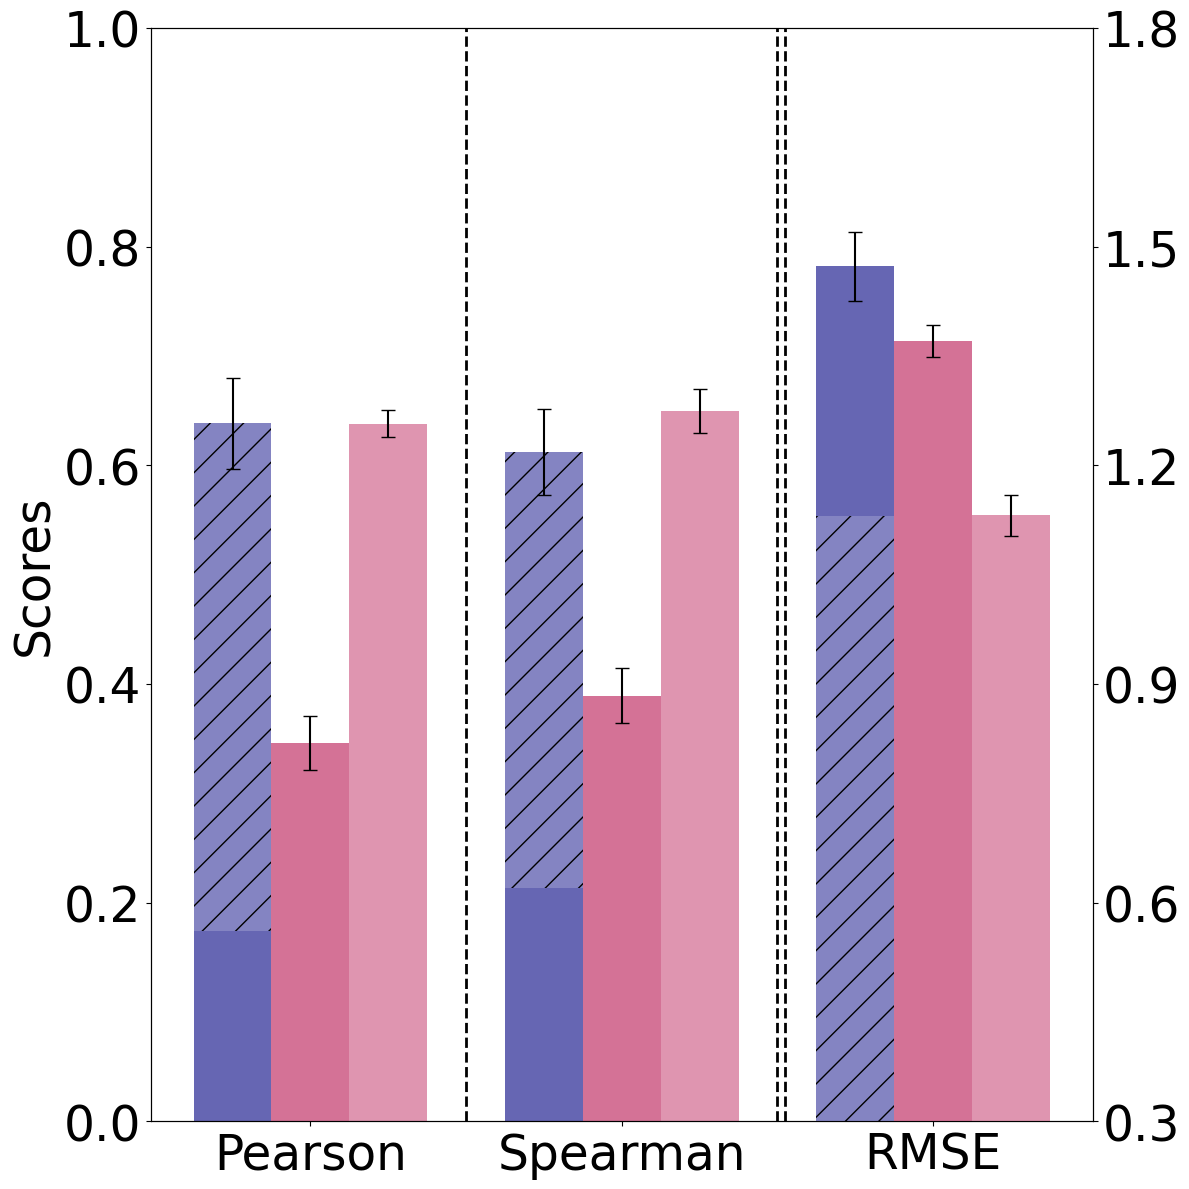

In [68]:

# Load the provided CSV files
file_path_1 = 'MPro/Mpro_preds+GP_final.csv'
file_path_2 = 'MPro/Mpro_ZeroShot.csv'
df_preds_gp = pd.read_csv(file_path_1)
df_zero_shot = pd.read_csv(file_path_2)

# Calculate zero-shot metrics for BALM
labels = df_zero_shot['label']
predictions = df_zero_shot['prediction']
zero_shot_metrics = {
    'Pearson': labels.corr(predictions, method='pearson'),
    'Spearman': labels.corr(predictions, method='spearman'),
    'RMSE': mean_squared_error(labels, predictions, squared=False)
}
balm_zero_shot_values = [zero_shot_metrics['Pearson'], zero_shot_metrics['Spearman'], zero_shot_metrics['RMSE']]

# Filter for few-shot (train_ratio=0.2) for BALM, GP_ECFP, and GP_ChemBERTa
metrics = ['test/pearson', 'test/spearman', 'test/rmse']
balm_few_shot = df_preds_gp[(df_preds_gp['Model'] == 'BALM') & (df_preds_gp['train_ratio'] == 0.2)]
gp_ecfp = df_preds_gp[(df_preds_gp['Model'] == 'GP_ECFP') & (df_preds_gp['train_ratio'] == 0.2)]
gp_chemberta = df_preds_gp[(df_preds_gp['Model'] == 'GP_ChemBERTa') & (df_preds_gp['train_ratio'] == 0.2)]

# Calculate standard deviation for error bars for few-shot entries
balm_few_shot_std = balm_few_shot[metrics].std().values
gp_ecfp_std = gp_ecfp[metrics].std().values
gp_chemberta_std = gp_chemberta[metrics].std().values

# Reconfirm RMSE values for accuracy
rmse_values = {
    'BALM_few_shot_rmse': balm_few_shot['test/rmse'].values[0] if not balm_few_shot.empty else None,
    'GP_ECFP_rmse': gp_ecfp['test/rmse'].values[0] if not gp_ecfp.empty else None,
    'GP_ChemBERTa_rmse': gp_chemberta['test/rmse'].values[0] if not gp_chemberta.empty else None,
    'BALM_zero_shot_rmse': zero_shot_metrics['RMSE']  # Previously calculated zero-shot RMSE
}

# Plotting setup with primary and secondary y-axes
fig, ax = plt.subplots(figsize=(12, 12))
ax1 = ax.twinx()
x = np.arange(len(metrics))
bar_width = 0.25

# Colors
balm_color = sns.color_palette([(0.4, 0.4, 0.7)]) # '#6A5ACD'  # medium slate blue 
gp_color = '#CA4F7C'

# Plot BALM for Pearson and Spearman on primary axis, RMSE on secondary axis
ax.bar(x[:2] - bar_width, balm_zero_shot_values[:2], width=bar_width, color=balm_color, label="BALM (zero-shot)")
ax.bar(x[:2] - bar_width, balm_few_shot[metrics[:2]].values[0] - balm_zero_shot_values[:2], 
       bottom=balm_zero_shot_values[:2], width=bar_width, color=balm_color, alpha=0.8, 
       hatch='/', label="BALM (few-shot)", yerr=balm_few_shot_std[:2], capsize=5)

# Plot RMSE for BALM on secondary axis with few-shot below, zero-shot difference on top
few_shot_rmse = rmse_values['BALM_few_shot_rmse']
zero_shot_rmse = rmse_values['BALM_zero_shot_rmse']
rmse_difference = zero_shot_rmse - few_shot_rmse
ax1.bar(x[2] - bar_width, few_shot_rmse, width=bar_width, color=balm_color, alpha=0.8, hatch='/')
ax1.bar(x[2] - bar_width, rmse_difference, bottom=few_shot_rmse, width=bar_width, color=balm_color, 
       yerr=balm_few_shot_std[2], capsize=5)

# Plot GP_ECFP with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2], gp_ecfp[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
       label="GP (ECFP)", yerr=gp_ecfp_std[:2], capsize=5)
ax1.bar(x[2], gp_ecfp[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
        yerr=gp_ecfp_std[2], capsize=5)

# Plot GP_Chemberta with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2] + bar_width, gp_chemberta[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
       label="GP (ChemBERTa)", yerr=gp_chemberta_std[:2], capsize=5)
ax1.bar(x[2] + bar_width, gp_chemberta[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
        yerr=gp_chemberta_std[2], capsize=5)

# Add double dotted lines to separate metrics
for i in [0.5, 1.5]:
    ax.axvline(x=i, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)
ax.axvline(x=1.525, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)

# Customize y-axes
ax.set_ylim([0, 1])
ax.set_yticks([0 + i * 0.2 for i in range(6)])
ax1.set_ylim([0.3, 1.8])
ax1.set_yticks([0.3 + i * 0.3 for i in range(6)])

# Customize x-axis and remove x-axis label
metric_names = ["Pearson", "Spearman", "RMSE"]
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=35)
ax.set_ylabel('Scores', fontsize=35)
ax1.set_ylabel('', fontsize=35, labelpad=15)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=35)
ax1.tick_params(axis='both', which='major', labelsize=35)

# Adjust legend position and remove extra legend handles
#ax.legend(loc='lower left', fontsize=20)
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'Mpro_bar.png'), dpi=500, bbox_inches='tight')
# Show the plot
plt.show()


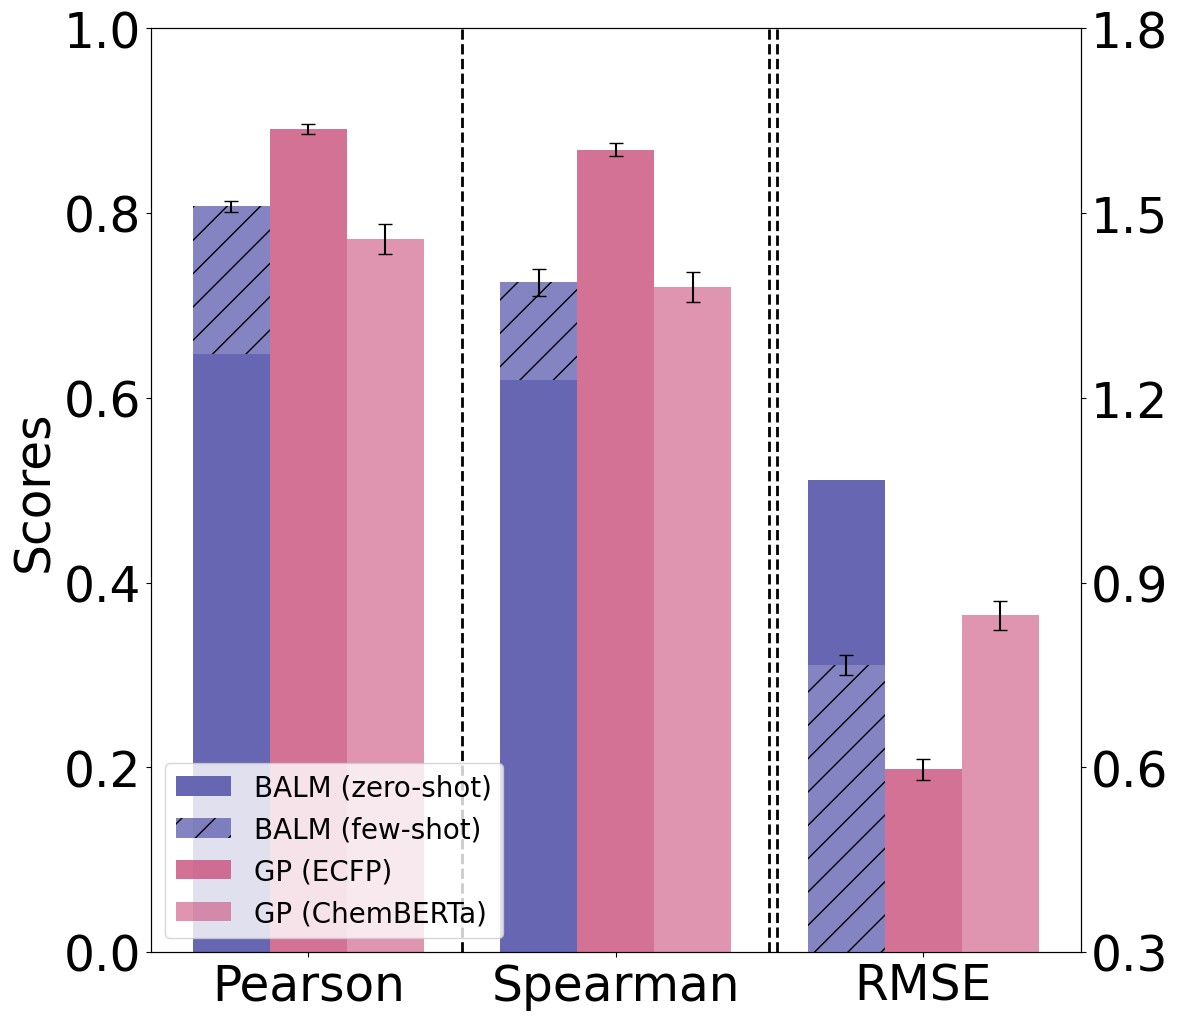

In [38]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr
from sklearn.metrics import mean_squared_error
import seaborn as sns

# Load the provided CSV files
file_path_1 = 'USP7/USP7_preds+GP_final.csv'
file_path_2 = 'USP7/USP7_f_zershot_BDBClean.csv'
df_preds_gp = pd.read_csv(file_path_1)
df_zero_shot = pd.read_csv(file_path_2)

# Calculate zero-shot metrics for BALM
labels = df_zero_shot['label']
predictions = df_zero_shot['prediction']
zero_shot_metrics = {
    'Pearson': labels.corr(predictions, method='pearson'),
    'Spearman': labels.corr(predictions, method='spearman'),
    'RMSE': mean_squared_error(labels, predictions, squared=False)
}
balm_zero_shot_values = [zero_shot_metrics['Pearson'], zero_shot_metrics['Spearman'], zero_shot_metrics['RMSE']]

# Filter for few-shot (train_ratio=0.2) for BALM, GP_ECFP, and GP_ChemBERTa
metrics = ['test/pearson', 'test/spearman', 'test/rmse']
balm_few_shot = df_preds_gp[(df_preds_gp['Model'] == 'BALM') & (df_preds_gp['train_ratio'] == 0.2)]
gp_ecfp = df_preds_gp[(df_preds_gp['Model'] == 'GP_ECFP') & (df_preds_gp['train_ratio'] == 0.2)]
gp_chemberta = df_preds_gp[(df_preds_gp['Model'] == 'GP_ChemBERTa') & (df_preds_gp['train_ratio'] == 0.2)]

# Calculate standard deviation for error bars for few-shot entries
balm_few_shot_std = balm_few_shot[metrics].std().values
gp_ecfp_std = gp_ecfp[metrics].std().values
gp_chemberta_std = gp_chemberta[metrics].std().values

# Reconfirm RMSE values for accuracy
rmse_values = {
    'BALM_few_shot_rmse': balm_few_shot['test/rmse'].values[0] if not balm_few_shot.empty else None,
    'GP_ECFP_rmse': gp_ecfp['test/rmse'].values[0] if not gp_ecfp.empty else None,
    'GP_ChemBERTa_rmse': gp_chemberta['test/rmse'].values[0] if not gp_chemberta.empty else None,
    'BALM_zero_shot_rmse': zero_shot_metrics['RMSE']  # Previously calculated zero-shot RMSE
}

# Plotting setup with primary and secondary y-axes
fig, ax = plt.subplots(figsize=(12, 12))
ax1 = ax.twinx()
x = np.arange(len(metrics))
bar_width = 0.25

# Colors
balm_color = sns.color_palette([(0.4, 0.4, 0.7)]) # '#6A5ACD'  # medium slate blue 
gp_color = '#CA4F7C'

# Plot BALM for Pearson and Spearman on primary axis, RMSE on secondary axis
ax.bar(x[:2] - bar_width, balm_zero_shot_values[:2], width=bar_width, color=balm_color, label="BALM (zero-shot)")
ax.bar(x[:2] - bar_width, balm_few_shot[metrics[:2]].values[0] - balm_zero_shot_values[:2], 
       bottom=balm_zero_shot_values[:2], width=bar_width, color=balm_color, alpha=0.8, 
       hatch='/', label="BALM (few-shot)", yerr=balm_few_shot_std[:2], capsize=5)

# Plot RMSE for BALM on secondary axis with few-shot below, zero-shot difference on top, with error bar on few-shot RMSE
few_shot_rmse = rmse_values['BALM_few_shot_rmse']
zero_shot_rmse = rmse_values['BALM_zero_shot_rmse']
rmse_difference = zero_shot_rmse - few_shot_rmse
ax1.bar(x[2] - bar_width, few_shot_rmse, width=bar_width, color=balm_color, alpha=0.8, hatch='/',
        yerr=balm_few_shot_std[2], capsize=5)  # Error bar on few-shot RMSE
ax1.bar(x[2] - bar_width, rmse_difference, bottom=few_shot_rmse, width=bar_width, color=balm_color)

# Plot GP_ECFP with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2], gp_ecfp[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
       label="GP (ECFP)", yerr=gp_ecfp_std[:2], capsize=5)
ax1.bar(x[2], gp_ecfp[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.8, 
        yerr=gp_ecfp_std[2], capsize=5)

# Plot GP_Chemberta with Pearson and Spearman on primary axis, RMSE on secondary
ax.bar(x[:2] + bar_width, gp_chemberta[metrics[:2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
       label="GP (ChemBERTa)", yerr=gp_chemberta_std[:2], capsize=5)
ax1.bar(x[2] + bar_width, gp_chemberta[metrics[2]].values[0], width=bar_width, color=gp_color, alpha=0.6, 
        yerr=gp_chemberta_std[2], capsize=5)

# Add double dotted lines to separate metrics
for i in [0.5, 1.5]:
    ax.axvline(x=i, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)
ax.axvline(x=1.525, ymin=0, ymax=1, color='black', linestyle='--', linewidth=2)

# Customize y-axes
ax.set_ylim([0, 1])
ax.set_yticks([0 + i * 0.2 for i in range(6)])
ax1.set_ylim([0.3, 1.8])
ax1.set_yticks([0.3 + i * 0.3 for i in range(6)])

# Customize x-axis and remove x-axis label
metric_names = ["Pearson", "Spearman", "RMSE"]
ax.set_xticks(x)
ax.set_xticklabels(metric_names, fontsize=35)
ax.set_ylabel('Scores', fontsize=35)
ax1.set_ylabel('', fontsize=35, labelpad=15)

# Customize tick parameters
ax.tick_params(axis='both', which='major', labelsize=35)
ax1.tick_params(axis='both', which='major', labelsize=35)

# Adjust legend position and remove extra legend handles
ax.legend(loc='lower left', fontsize=20)

# Show the plot
plt.show()


## Scatter plots

In [54]:
import numpy as np
import pandas as pd
from typing import Tuple

def pic50_to_dg(
    pic50: float,
    uncertainty: float,
    temperature: float = 298.15
) -> Tuple[float, float]:
    """
    Convert the PIC50 value and its uncertainty to dg.

    Notes:
        We use a different function for this due to the slightly different error propagation formula.
        uncertainty calculated using:
        G = RTLn(Ki)
        Ki = 10^(-pK)
        sigma(G) = dG/dKi * sigma(Ki)
        sigma(G) = sigma(pK) * RT * d Ln(10^-pK) / dpK
        sigma(G) = sigma(pK) * RT * Ln(10)

    Args:
        pic50: The pIC50 value.
        uncertainty: The standard deviation in the pIC50 value
        temperature: Experimental temperature. Default: 298.15 * unit.kelvin.

    Returns:
        dg: Gibbs binding free energy.
        ddg: Error in binding free energy.
    """
    R_kcal = 0.0019872041  # Gas constant in kcal/(mol*K)
    
    # Convert PIC50 to Ki (inhibition constant)
    ki = 10 ** (-pic50)  # Molar

    # Calculate ΔG
    dg = R_kcal * temperature * np.log(ki)

    # Calculate the uncertainty in ΔG
    ddg = R_kcal * temperature * np.log(10) * uncertainty

    return dg, ddg


### Zero shot BALM

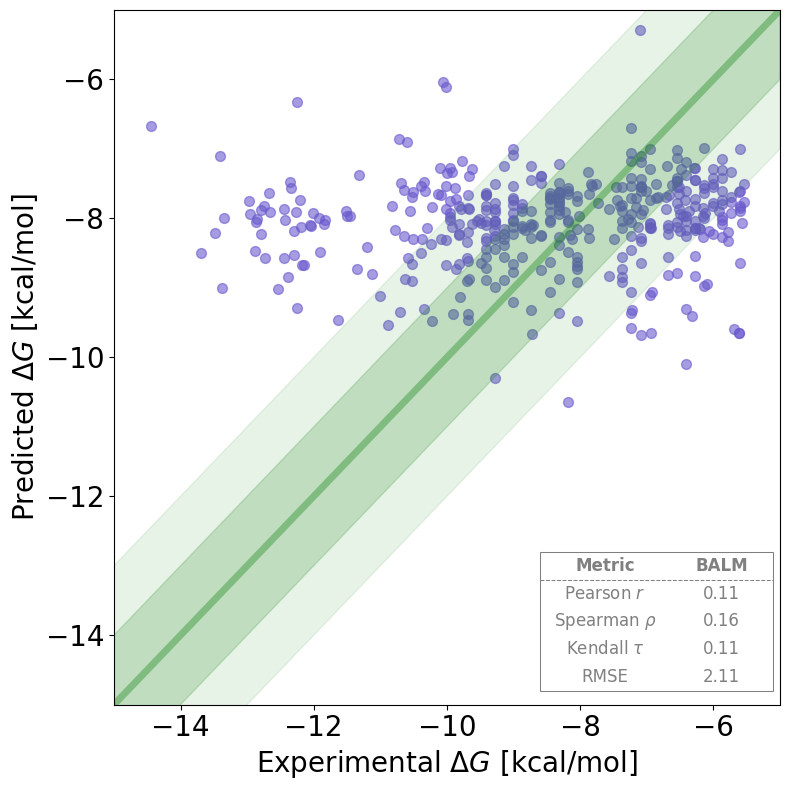

In [73]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D



# Load the data
file_path = 'MPro_final/Mpro_ZeroShot.csv'
data = pd.read_csv(file_path)
uncertainty_value = 0.1

# Convert pIC50 to dG for both label and prediction
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

# Randomly select 20% of the data
sampled_data = data.sample(frac=0.2, random_state=20)

# Calculate Pearson, Spearman, and Kendall correlations
pearson_corr, _ = pearsonr(sampled_data['label_dG'], sampled_data['prediction_dG'])
spearman_corr, _ = spearmanr(sampled_data['label_dG'], sampled_data['prediction_dG'])
kendall_corr, _ = kendalltau(sampled_data['label_dG'], sampled_data['prediction_dG'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sampled_data['label_dG'], sampled_data['prediction_dG']))

# Formatting the values for display
pearson_corr = f"{pearson_corr:.2f}"
spearman_corr = f"{spearman_corr:.2f}"
kendall_corr = f"{kendall_corr:.2f}"
rmse = f"{rmse:.2f}"

# Prepare table data with computed values
table_data = [
    ['Metric', 'BALM'],
    ['Pearson $r$', pearson_corr],
    ['Spearman $\\rho$', spearman_corr],
    ['Kendall $\\tau$', kendall_corr],
    ['RMSE', rmse]
]

# Scatter plot setup
plt.figure(figsize=(8, 8))
plt.scatter(sampled_data['label_dG'], sampled_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50)

# Identity line and shaded bands
x = np.linspace(-15, -5, 100)
y = x
plt.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)

# Set axis limits and labels
plt.xlim(-15, -5)
plt.ylim(-15, -5)
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding the table
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.65, 0.02, 0.35, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)

# Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)  # No inner cell borders initially
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=12)
    if row==0 and col == 1:
        cell.set_text_props(fontweight='bold')

#     if row == 0:
#         cell.set_text_props(fontsize=14)  # Header row
#         #cell.set_linewidth(1.0)  # Solid line below header
#     if col == 1:
#         cell.set_text_props(fontweight='normal')  # No bold font

# Bounding box and custom border
bbox = table.get_window_extent(ax.figure.canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

# Rectangle around table
rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

# Dotted line below header row
line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Display plot
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'Mpro_zero_shot.png'), dpi=500, bbox_inches='tight')
plt.show()


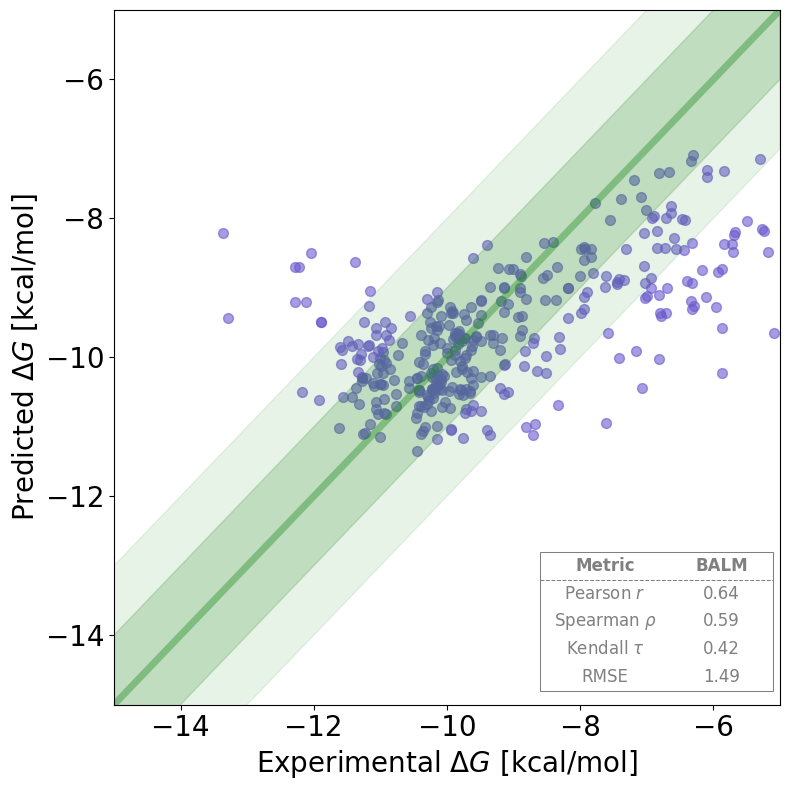

In [74]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D



# Load the data
file_path = 'USP7/USP7_f_zershot_BDBClean.csv'
data = pd.read_csv(file_path)
uncertainty_value = 0.1

# Convert pIC50 to dG for both label and prediction
data['label_dG'] = data.apply(lambda row: pic50_to_dg(row['label'], uncertainty_value)[0], axis=1)
data['prediction_dG'] = data.apply(lambda row: pic50_to_dg(row['prediction'], uncertainty_value)[0], axis=1)

# Randomly select 20% of the data
sampled_data = data.sample(frac=0.2, random_state=20)

# Calculate Pearson, Spearman, and Kendall correlations
pearson_corr, _ = pearsonr(sampled_data['label_dG'], sampled_data['prediction_dG'])
spearman_corr, _ = spearmanr(sampled_data['label_dG'], sampled_data['prediction_dG'])
kendall_corr, _ = kendalltau(sampled_data['label_dG'], sampled_data['prediction_dG'])

# Calculate RMSE
rmse = np.sqrt(mean_squared_error(sampled_data['label_dG'], sampled_data['prediction_dG']))

# Formatting the values for display
pearson_corr = f"{pearson_corr:.2f}"
spearman_corr = f"{spearman_corr:.2f}"
kendall_corr = f"{kendall_corr:.2f}"
rmse = f"{rmse:.2f}"

# Prepare table data with computed values
table_data = [
    ['Metric', 'BALM'],
    ['Pearson $r$', pearson_corr],
    ['Spearman $\\rho$', spearman_corr],
    ['Kendall $\\tau$', kendall_corr],
    ['RMSE', rmse]
]

# Scatter plot setup
plt.figure(figsize=(8, 8))
plt.scatter(sampled_data['label_dG'], sampled_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50)

# Identity line and shaded bands
x = np.linspace(-15, -5, 100)
y = x
plt.plot(x, y, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, y - 1, y + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, y - 2, y + 2, color='#228B22', alpha=0.1)

# Set axis limits and labels
plt.xlim(-15, -5)
plt.ylim(-15, -5)
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Adding the table
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.65, 0.02, 0.35, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(12)

# Style table cells
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)  # No inner cell borders initially
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=12)
    if row==0 and col == 1:
        cell.set_text_props(fontweight='bold')

#     if row == 0:
#         cell.set_text_props(fontsize=14)  # Header row
#         #cell.set_linewidth(1.0)  # Solid line below header
#     if col == 1:
#         cell.set_text_props(fontweight='normal')  # No bold font

# Bounding box and custom border
bbox = table.get_window_extent(ax.figure.canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

# Rectangle around table
rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

# Dotted line below header row
line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Display plot
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'USP7_zero_shot.png'), dpi=500, bbox_inches='tight')
plt.show()


### Few-shot (BALM and GP)

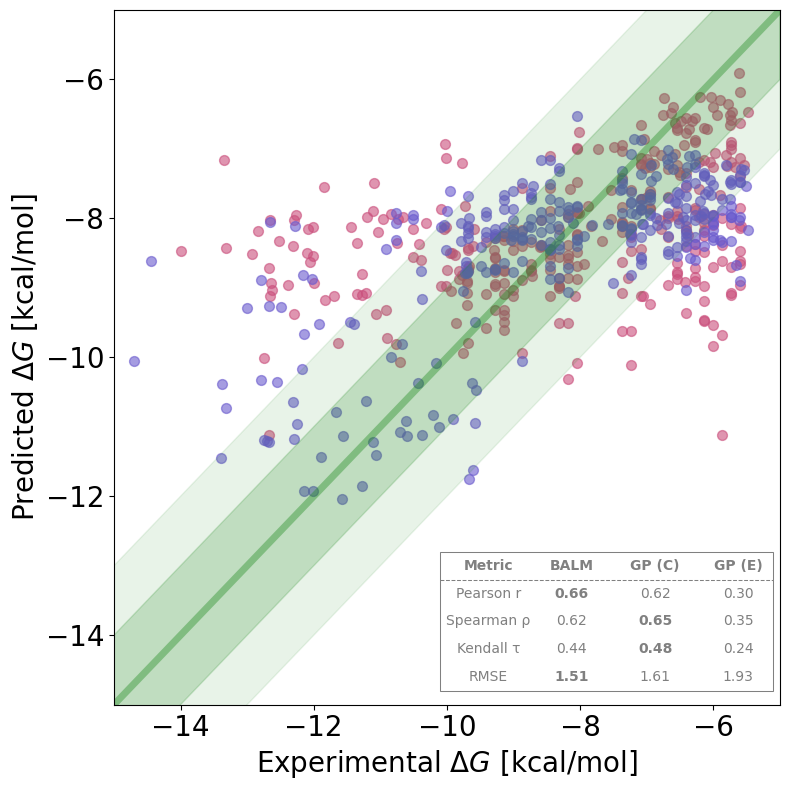

In [83]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Load data files
few_shot_data = pd.read_csv('MPro_final/Mpro_FewShot.csv')
gp_chemberta_data = pd.read_csv('MPro_final/GP_Chemberta_MPro_fewShot.csv')
gp_ecfp_data = pd.read_csv('MPro_final/GP_ECFP_MPro_fewShot.csv')


# Convert label and prediction values to ΔG
uncertainty_value = 0.1
for df in [few_shot_data, gp_chemberta_data, gp_ecfp_data]:
    df['label_dG'] = df['label'].apply(lambda x: pic50_to_dg(x, uncertainty_value)[0])
    df['prediction_dG'] = df['prediction'].apply(lambda x: pic50_to_dg(x, uncertainty_value)[0])

# Calculate metrics for each dataset
metrics = {
    'BALM': {
        "pearson": pearsonr(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "spearman": spearmanr(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "kendall": kendalltau(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(few_shot_data['label_dG'], few_shot_data['prediction_dG']))
    },
    'GP (ChemBERTa)': {
        "pearson": pearsonr(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "spearman": spearmanr(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "kendall": kendalltau(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG']))
    },
    'GP (ECFP)': {
        "pearson": pearsonr(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "spearman": spearmanr(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "kendall": kendalltau(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG']))
    }
}

# Prepare table data for display
table_data = [
    ["Metric", "BALM", "GP (C)", "GP (E)"],
    ["Pearson r", f"{metrics['BALM']['pearson']:.2f}", f"{metrics['GP (ChemBERTa)']['pearson']:.2f}", f"{metrics['GP (ECFP)']['pearson']:.2f}"],
    ["Spearman ρ", f"{metrics['BALM']['spearman']:.2f}", f"{metrics['GP (ChemBERTa)']['spearman']:.2f}", f"{metrics['GP (ECFP)']['spearman']:.2f}"],
    ["Kendall τ", f"{metrics['BALM']['kendall']:.2f}", f"{metrics['GP (ChemBERTa)']['kendall']:.2f}", f"{metrics['GP (ECFP)']['kendall']:.2f}"],
    ["RMSE", f"{metrics['BALM']['rmse']:.2f}", f"{metrics['GP (ChemBERTa)']['rmse']:.2f}", f"{metrics['GP (ECFP)']['rmse']:.2f}"]
]

few_shot_data= few_shot_data.sample(frac=0.2, random_state=20)
gp_chemberta_data=gp_chemberta_data.sample(frac=0.2, random_state=20)
gp_ecfp_data=gp_ecfp_data.sample(frac=0.2, random_state=20)

# Plotting
plt.figure(figsize=(8, 8))

# Scatter plots
plt.scatter(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'], color='#CA4F7C', alpha=0.6, s=50, label='GP (Best)')
plt.scatter(few_shot_data['label_dG'], few_shot_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM (few-shot)')
#plt.scatter(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'], color='#CA4F7C', alpha=0.6, s=50, label='GP (ChemBERTa) ')


# Identity line and uncertainty bands
x = np.linspace(-15, -5, 100)
plt.plot(x, x, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

# Axis settings
plt.xlim(-15, -5)
plt.ylim(-15, -5)
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Table display
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.5, 0.02, 0.5, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Style table cells for best readability
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Highlight header and best values
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=10)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_chemberta = float(table_data[row][2])
            val_ecfp = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_chemberta, val_ecfp)) or \
                   (col == 2 and val_chemberta <= min(val_balm, val_ecfp)) or \
                   (col == 3 and val_ecfp <= min(val_balm, val_chemberta)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_chemberta, val_ecfp)) or \
                   (col == 2 and val_chemberta >= max(val_balm, val_ecfp)) or \
                   (col == 3 and val_ecfp >= max(val_balm, val_chemberta)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass

# Rectangle around table and dotted line below header
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Legend and layout adjustments
#plt.legend(fontsize=12)
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'Mpro_few_shot.png'), dpi=500, bbox_inches='tight')
plt.show()


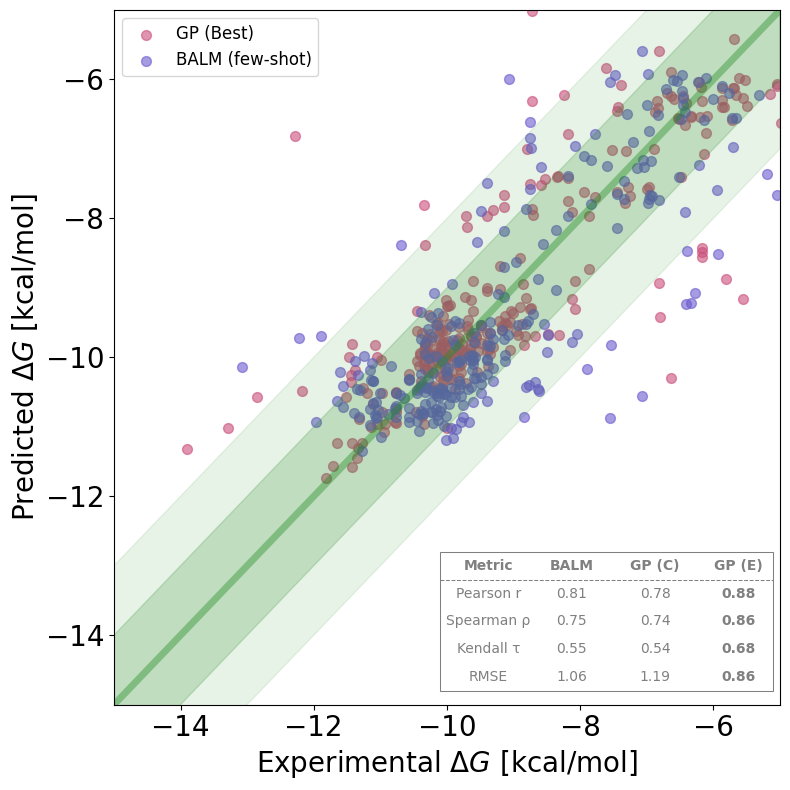

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, kendalltau
from sklearn.metrics import mean_squared_error
from matplotlib.patches import Rectangle
from matplotlib.lines import Line2D

# Load data files
few_shot_data = pd.read_csv('USP7/USP7_f_preds_BDB_clean.csv')
gp_chemberta_data = pd.read_csv('USP7/GP_Chemberta_USP7_fewShot.csv')
gp_ecfp_data = pd.read_csv('USP7/GP_ECFP_USP7_fewShot.csv')

# few_shot_data= few_shot_data.sample(frac=0.2, random_state=20)
# gp_chemberta_data=gp_chemberta_data.sample(frac=0.2, random_state=20)
# gp_ecfp_data=gp_ecfp_data.sample(frac=0.2, random_state=20)

# Convert label and prediction values to ΔG
uncertainty_value = 0.1
for df in [few_shot_data, gp_chemberta_data, gp_ecfp_data]:
    df['label_dG'] = df['label'].apply(lambda x: pic50_to_dg(x, uncertainty_value)[0])
    df['prediction_dG'] = df['prediction'].apply(lambda x: pic50_to_dg(x, uncertainty_value)[0])

# Calculate metrics for each dataset
metrics = {
    'BALM': {
        "pearson": pearsonr(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "spearman": spearmanr(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "kendall": kendalltau(few_shot_data['label_dG'], few_shot_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(few_shot_data['label_dG'], few_shot_data['prediction_dG']))
    },
    'GP (ChemBERTa)': {
        "pearson": pearsonr(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "spearman": spearmanr(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "kendall": kendalltau(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG']))
    },
    'GP (ECFP)': {
        "pearson": pearsonr(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "spearman": spearmanr(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "kendall": kendalltau(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'])[0],
        "rmse": np.sqrt(mean_squared_error(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG']))
    }
}

# Prepare table data for display
table_data = [
    ["Metric", "BALM", "GP (C)", "GP (E)"],
    ["Pearson r", f"{metrics['BALM']['pearson']:.2f}", f"{metrics['GP (ChemBERTa)']['pearson']:.2f}", f"{metrics['GP (ECFP)']['pearson']:.2f}"],
    ["Spearman ρ", f"{metrics['BALM']['spearman']:.2f}", f"{metrics['GP (ChemBERTa)']['spearman']:.2f}", f"{metrics['GP (ECFP)']['spearman']:.2f}"],
    ["Kendall τ", f"{metrics['BALM']['kendall']:.2f}", f"{metrics['GP (ChemBERTa)']['kendall']:.2f}", f"{metrics['GP (ECFP)']['kendall']:.2f}"],
    ["RMSE", f"{metrics['BALM']['rmse']:.2f}", f"{metrics['GP (ChemBERTa)']['rmse']:.2f}", f"{metrics['GP (ECFP)']['rmse']:.2f}"]
]

few_shot_data= few_shot_data.sample(frac=0.2, random_state=20)
gp_chemberta_data=gp_chemberta_data.sample(frac=0.2, random_state=20)
gp_ecfp_data=gp_ecfp_data.sample(frac=0.2, random_state=20)
# Plotting
plt.figure(figsize=(8, 8))

# Scatter plots
plt.scatter(gp_ecfp_data['label_dG'], gp_ecfp_data['prediction_dG'], color='#CA4F7C', alpha=0.6, s=50, label='GP (Best)')
plt.scatter(few_shot_data['label_dG'], few_shot_data['prediction_dG'], color='#6A5ACD', alpha=0.6, s=50, label='BALM (few-shot)')
#plt.scatter(gp_chemberta_data['label_dG'], gp_chemberta_data['prediction_dG'], color='#CA4F7C', alpha=0.6, s=50, label='GP (ChemBERTa) ')

# Identity line and uncertainty bands
x = np.linspace(-15, -5, 100)
plt.plot(x, x, color='#228B22', linestyle='-', linewidth=5, alpha=0.4)
plt.fill_between(x, x - 1, x + 1, color='#228B22', alpha=0.2)
plt.fill_between(x, x - 2, x + 2, color='#228B22', alpha=0.1)

# Axis settings
plt.xlim(-15, -5)
plt.ylim(-15, -5)
plt.ylabel(r'Predicted $\Delta G$ [kcal/mol]', fontsize=20)
plt.xlabel(r'Experimental $\Delta G$ [kcal/mol]', fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Table display
ax = plt.gca()
table = ax.table(cellText=table_data, cellLoc='center', loc='lower right', bbox=[0.5, 0.02, 0.5, 0.2])
table.auto_set_font_size(False)
table.set_fontsize(10)

# Style table cells for best readability
for (row, col), cell in table.get_celld().items():
    cell.set_text_props(color='grey', ha='center')
    cell.PAD = 0.1
    cell.set_linewidth(0)

    # Highlight header and best values
    if row == 0:
        cell.set_text_props(fontweight='bold', fontsize=10)
    elif row > 0 and col > 0:
        try:
            # Bold best values (highest for correlations, lowest for RMSE)
            val_balm = float(table_data[row][1])
            val_chemberta = float(table_data[row][2])
            val_ecfp = float(table_data[row][3])
            if row == 4:  # RMSE row
                if (col == 1 and val_balm <= min(val_chemberta, val_ecfp)) or \
                   (col == 2 and val_chemberta <= min(val_balm, val_ecfp)) or \
                   (col == 3 and val_ecfp <= min(val_balm, val_chemberta)):
                    cell.set_text_props(fontweight='bold')
            else:
                if (col == 1 and val_balm >= max(val_chemberta, val_ecfp)) or \
                   (col == 2 and val_chemberta >= max(val_balm, val_ecfp)) or \
                   (col == 3 and val_ecfp >= max(val_balm, val_chemberta)):
                    cell.set_text_props(fontweight='bold')
        except ValueError:
            pass

# Rectangle around table and dotted line below header
bbox = table.get_window_extent(plt.gcf().canvas.get_renderer())
inv = ax.transAxes.inverted()
bbox = inv.transform(bbox)
x0, y0 = bbox[0]
x1, y1 = bbox[1]

rect = Rectangle((x0 - 0.01, y0), x1 - x0, y1 - y0, linewidth=0.75, edgecolor='grey', facecolor='none', transform=ax.transAxes)
ax.add_patch(rect)

line_y = y0 + (y1 - y0) * 0.8
line = Line2D([x0 - 0.01, x1 - 0.01], [line_y, line_y], color='grey', linestyle='--', linewidth=0.75, transform=ax.transAxes)
ax.add_line(line)

# Legend and layout adjustments
plt.legend(fontsize=12)
plt.tight_layout()
output_dir = 'Fig3_plots/'
plt.savefig(os.path.join(output_dir, 'USP7_few_shot.png'), dpi=500, bbox_inches='tight')
plt.show()
